This script can be use to perform z-score normalization of all images belonging to a certain database.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def Rotating(im_array):
    '''rotating an image represented by a numpy array over 90°, 180° and 270°'''
    
    im_90 = np.rot90(im_array)
    im_180 = np.rot90(im_90)
    im_270 = np.rot90(im_180)
    
    return im_90,im_180,im_270

In [7]:
def Flipping(im_array):
    '''Mirroring an image represented by a numpy array, along a horizontal and vertical axis'''
    
    im_flipped_0 = np.flip(im_array, axis = 0)
    im_flipped_1 = np.flip(im_array, axis = 1)
    
    return im_flipped_0, im_flipped_1

In [138]:
# Calculate mean
def Mean(Datapath):
    '''
    This function calculates the mean per pixel for the complete train set
    The datapath indicates where all data arrays can be found 
    '''
    train_images = np.load(Datapath + 'train_images.npy')
    train_images = train_images/255
    
    # define whether the images are greyscale or rgb images
    n = len(train_images.shape)
    
    # greyscal images
    if n == 3:
        mean = np.mean(train_images, axis = 0)
    else:
        intermediate_mean = np.mean(train_images, axis = 3)
        mean = np.mean(intermediate_mean, axis = 0)
   
    # to calculate the total mean the mean also has to be defined for the augmented images
    mean_90,mean_180,mean_270 = Rotating(mean)
    mean_flip0, mean_flip1 = Flipping(mean)
    
    # bring all means together
    all_means = np.stack([mean, mean_90, mean_180, mean_270, mean_flip0, mean_flip1], axis=0)
    total_mean = np.mean(all_means, axis = 0)
    
    return total_mean

In [139]:
def Variance(Datapath_Array, totalmean):
    '''
    This function calculates the variance per pixel for all images of an array
    Datapath_array indicates the datapath for the array
    '''
    train_images = np.load(Datapath_Array)
    train_images = train_images/255
    n = len(train_images.shape)
    m = train_images.shape[0]
    
    # greyscale images
    if n == 3:
        var = np.sum((train_images-totalmean)**2, axis = 0)
        
    # rgb images
    elif n == 4:
        # calculate the variance per channel
        R_chan = train_images[:,:,:,0]
        G_chan = train_images[:,:,:,1]
        B_chan = train_images[:,:,:,2]
        
        var_R = np.sum((R_chan-totalmean)**2, axis = 0)
        var_G = np.sum((G_chan-totalmean)**2, axis = 0)
        var_B = np.sum((B_chan-totalmean)**2, axis = 0)
        
        # bring all channels together
        var = np.sum(np.stack([var_R, var_G, var_B], axis = 0), axis = 0)
        
    return var, m

In [101]:
# Calculate standard deviation
def StandardDeviation(Datapath, TotalMean):
    '''
    This function calculates the standard deviation per pixel for the complete train set
    The datapath indicates where all data arrays can be found
    '''
    
    # define the variance for the different datapaths
    var, m = Variance(Datapath+'train_images.npy', TotalMean)
    var_90, _ = Variance(Datapath+'train_images_90.npy', TotalMean)
    var_180, _ = Variance(Datapath+'train_images_180.npy', TotalMean)
    var_270, _ = Variance(Datapath+'train_images_270.npy', TotalMean)
    var_flip0, _ = Variance(Datapath+'train_images_flip0.npy', TotalMean)
    var_flip1, _ = Variance(Datapath+'train_images_flip1.npy', TotalMean)
    
    # bring all variances together and calculate the total standard deviation
    total_var = np.sum(np.stack([var, var_90, var_180, var_270, var_flip0, var_flip1], axis = 0), axis = 0)
    
    total_std_dev = np.sqrt( 1/(6*m) * total_var)
    
    return total_std_dev
    

In [140]:
def ZscoreNormalization(Datapath_Array, mean, std_dev):
    '''
    This function performs z-score normalization for all images found at
    the indicated data path (Datapath_Array) according to the indicated mean and std_dev
    The normalized arrays are stored at the end
    '''
    
    print('Z-score normalization for: {}'.format(Datapath_Array))
    
    # read in the data array
    im_array = np.load(Datapath_Array)
    im_array = im_array/255
    n = len(im_array.shape)
    
    # grey scal images
    if n == 3:
        norm_im_array = (im_array - mean)/std_dev
    
    # rgb images
    elif n == 4:
        # normalization can be done per color channel
        # channels have to be brought back together again at the end
        R_chan = im_array[:,:,:,0]
        G_chan = im_array[:,:,:,1]
        B_chan = im_array[:,:,:,2]
        
        norm_R_chan = (R_chan - mean)/std_dev
        norm_G_chan = (G_chan - mean)/std_dev
        norm_B_chan = (B_chan - mean)/std_dev
        
        norm_im_array = np.stack((norm_R_chan, norm_G_chan, norm_B_chan), axis = 3)
        
    # saving the normalized array
    savepath = Datapath_Array[:-4] +'_norm.npy'
    np.save(savepath, norm_im_array)

In [141]:
def Normalization(Datapath):
    '''
    This function normalizes all images (train and test images) that are found as arrays
    at the given Datapath
    Normalization is done according to z-score normalization and
    the same mean and standard deviation are used for the test set as calculated for the train set
    '''

    # calculate the mean on the train images
    print('Calculating the mean...')
    total_mean = Mean(Datapath)
    
    # calculate the standard deviation on the train images
    print('Calculating the standard deviation...')
    total_stddev = StandardDeviation(Datapath, total_mean)
    
    # perform z-score normalization for all train images
    ZscoreNormalization(Datapath + 'train_images.npy', total_mean, total_stddev)
    ZscoreNormalization(Datapath + 'train_images_90.npy', total_mean, total_stddev)
    ZscoreNormalization(Datapath + 'train_images_180.npy', total_mean, total_stddev)
    ZscoreNormalization(Datapath + 'train_images_270.npy', total_mean, total_stddev)
    ZscoreNormalization(Datapath + 'train_images_flip0.npy', total_mean, total_stddev)
    ZscoreNormalization(Datapath + 'train_images_flip1.npy', total_mean, total_stddev)
    
    # perform z-scor normalization for all test images
    ZscoreNormalization(Datapath + 'test_images.npy', total_mean, total_stddev)
    ZscoreNormalization(Datapath + 'test_images_90.npy', total_mean, total_stddev)
    ZscoreNormalization(Datapath + 'test_images_180.npy', total_mean, total_stddev)
    ZscoreNormalization(Datapath + 'test_images_270.npy', total_mean, total_stddev)
    ZscoreNormalization(Datapath + 'test_images_flip0.npy', total_mean, total_stddev)
    ZscoreNormalization(Datapath + 'test_images_flip1.npy', total_mean, total_stddev)
    
    print('Done')

In [166]:
# normalization has to be done for different datapaths
Base = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/'
# DataPath = Base + 'CHASEDB1/Arrays/'
# DataPath = Base + 'DRIVE/Arrays/'
# DataPath = Base + 'STARE/Arrays/'
# DataPath = Base + 'IDRiD/HardExudates/Arrays/'
# DataPath = Base + 'IDRiD/SoftExudates/Arrays/'
# DataPath = Base + 'IDRiD/Hemorrhages/Arrays/'
# DataPath = Base + 'IDRiD/Microaneurysms/Arrays/'

In [167]:
Normalization(DataPath)

Calculating the mean...
Calculating the standard deviation...
Z-score normalization for: C:/Users/lunam/Documents/1steMaster/Stage/Data/IDRiD/Microaneurysms/Arrays/train_images.npy
Z-score normalization for: C:/Users/lunam/Documents/1steMaster/Stage/Data/IDRiD/Microaneurysms/Arrays/train_images_90.npy
Z-score normalization for: C:/Users/lunam/Documents/1steMaster/Stage/Data/IDRiD/Microaneurysms/Arrays/train_images_180.npy
Z-score normalization for: C:/Users/lunam/Documents/1steMaster/Stage/Data/IDRiD/Microaneurysms/Arrays/train_images_270.npy
Z-score normalization for: C:/Users/lunam/Documents/1steMaster/Stage/Data/IDRiD/Microaneurysms/Arrays/train_images_flip0.npy
Z-score normalization for: C:/Users/lunam/Documents/1steMaster/Stage/Data/IDRiD/Microaneurysms/Arrays/train_images_flip1.npy
Z-score normalization for: C:/Users/lunam/Documents/1steMaster/Stage/Data/IDRiD/Microaneurysms/Arrays/test_images.npy
Z-score normalization for: C:/Users/lunam/Documents/1steMaster/Stage/Data/IDRiD/Mic

Below some tests are performed on the normalized images

In [ ]:
def PlotImage(image_array, database = '', image_name = '', save = False, savepath = ''):
    '''Visualize (and save if desired) an image represented by a numpy array'''
    
    plt.figure()
    plt.title(database+': '+image_name)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.imshow(image_array, cmap=plt.cm.Greys_r)
    
    if save == True:
        plt.savefig(savepath+database+'_'+image_name+'.png')
    
    return 

(20, 512, 512)


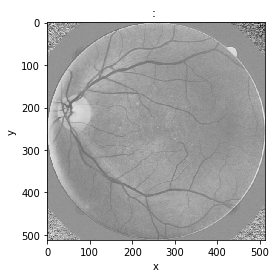

In [147]:
# some tests
norm_array = np.load('C:/Users/lunam/Documents/1steMaster/Stage/Data/DRIVE/Arrays/train_images_norm.npy')
print(norm_array.shape)

PlotImage(norm_array[0])

(20, 512, 512)
[-0.00896636 -0.00774673 -0.00737412 ...  0.0090285   0.00924613
  0.01019638]


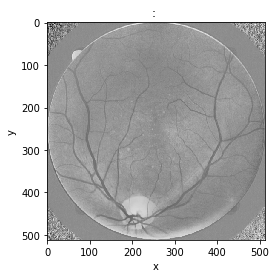

In [148]:
# some tests
norm_array = np.load('C:/Users/lunam/Documents/1steMaster/Stage/Data/DRIVE/Arrays/train_images_90_norm.npy')
print(norm_array.shape)

print(np.unique(norm_array[0]))
PlotImage(norm_array[0])

(26, 512, 512, 3)
[-0.00230779 -0.00229768 -0.00229744 ...  0.01207687  0.01289223
  0.01310975]


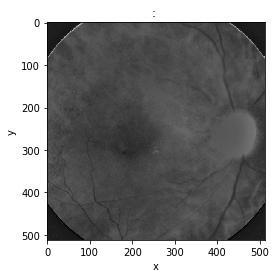

In [157]:
# some tests
norm_array = np.load('C:/Users/lunam/Documents/1steMaster/Stage/Data/IDRiD/SoftExudates/Arrays/train_images_norm.npy')
print(norm_array.shape)

PlotImage(norm_array[0,:,:,0])
print(np.unique(norm_array[0]))
# print(norm_array[0])